# Model summary
<hr>

### ResLFLB + ResNet18

In [1]:
from cv2 import transform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from einops import rearrange
import torch.nn.functional as F
from torchinfo import summary
from tqdm.auto import tqdm
from einops import rearrange
import random

In [2]:
def set_seed(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
    if torch.backends.cudnn.is_available:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f'# SEEDING DONE : seed is {seed_value} ')

set_seed(2022)

# SEEDING DONE : seed is 2022 


## LFLB (N Filter)

Speech emotion recognition using deep 1d & 2d cnn lstm networks. Biomedical Signal Processing and Control 47, 312–323 (2019)

In [3]:
class LFLB(nn.Module):
    """Some Information about LFLB"""
    def __init__(self, in_chan, out_chan, kernel=[2, 2], stride=[1, 1], pad=1):
        super(LFLB, self).__init__()

        self.cnn = nn.Conv2d(in_channels=in_chan, out_channels=out_chan, kernel_size=kernel, stride=stride, padding=pad)
        self.bn = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU()
        self.max_pool =  nn.MaxPool2d(kernel_size=kernel, stride=[2, 2])

    def forward(self, x):
        cnn_embd = self.cnn(x)
        cnn_embd = self.bn(cnn_embd)
        cnn_embd = self.relu(cnn_embd)
        output = self.max_pool(cnn_embd)

        return output

## NAC Unit

[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, Identity Mappings in Deep Residual Networks. arXiv:1603.05027
https://github.com/kuangliu/pytorch-cifar/blob/master/models/preact_resnet.py

In [4]:
class NACUnit(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, kernel, stride=1, pad=0):
        super(NACUnit, self).__init__()
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel, stride=stride, padding=pad, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        return out

In [5]:
class ResLFLB(nn.Module):
    def __init__(self, in_chan, n_filters, kernel):
        super(ResLFLB, self).__init__()
        
        self.lflb = LFLB(in_chan=in_chan, out_chan=n_filters)
        
        self.nac_unit1 = NACUnit(in_planes=n_filters, planes=n_filters, kernel=1, stride=1, pad=1)
        self.nac_unit2 = NACUnit(in_planes=n_filters, planes=n_filters, kernel=kernel, stride=1)
        self.nac_unit3 = NACUnit(in_planes=n_filters, planes=n_filters, kernel=kernel, stride=1)
        self.nac_unit4 = NACUnit(in_planes=n_filters, planes=n_filters, kernel=kernel, stride=1)
        self.nac_unit5 = NACUnit(in_planes=n_filters, planes=n_filters, kernel=1, stride=1)

    def forward(self, x):
        lflb_embd = self.lflb(x)
        
        nac_embd = self.nac_unit1(lflb_embd)
        nac_embd = self.nac_unit2(nac_embd)
        nac_embd = self.nac_unit3(nac_embd)
        nac_embd = self.nac_unit4(nac_embd)
        nac_embd = self.nac_unit5(nac_embd)
        
        output = lflb_embd + nac_embd

        return output

In [6]:
from torchvision.models import ResNet18_Weights

class resnet18_finetune(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model_ft = nn.Sequential(*(list(self.model_ft.children())[:-1]))
        
        for name, param in self.model_ft[:5].named_parameters():
            param.requires_grad=False
    
    def forward(self, x):
        embd = self.model_ft(x)
        output = torch.flatten(embd, start_dim=1)
        
        return output

In [7]:
class SpatialModel(nn.Module):
    def __init__(self):
        super(SpatialModel, self).__init__()

        self.resnet = resnet18_finetune()

        self.MFL = LFLB(3, 32)
        
        self.res_lflb1 = ResLFLB(32, 32, [3, 3])
        self.res_lflb2 = ResLFLB(32, 32, [3, 3])
        self.res_lflb3 = ResLFLB(32, 32, [3, 3])
        self.res_lflb4 = ResLFLB(32, 64, [3, 3])
        self.res_lflb5 = ResLFLB(64, 128, [3, 3])
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2])
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        res_embd = self.resnet(x)
        
        MFL_embd = self.MFL(x)
        
        res_lflb_embd = self.res_lflb1(MFL_embd)
        res_lflb_embd = self.res_lflb2(res_lflb_embd)
        res_lflb_embd = self.res_lflb3(res_lflb_embd)
        res_lflb_embd = self.res_lflb4(res_lflb_embd)
        res_lflb_embd = self.res_lflb5(res_lflb_embd)
        
        mlp = self.relu(res_lflb_embd)
        mlp = self.max_pool(mlp)
        mlp = self.dropout(mlp)
        mlp = torch.flatten(mlp, start_dim=1)
        
        output = mlp + res_embd
        
        return output

In [8]:
class TimeseriesModel(nn.Module):
    """Some Information about nna"""
    def __init__(self):
        super(TimeseriesModel, self).__init__()

        self.spatial = SpatialModel()

    def forward(self, x):
        spatial_embd = self.spatial(x)
        
        return spatial_embd

In [9]:
class Model(nn.Module):
    """Some Information about Model"""
    def __init__(self, num_emotions):
        super(Model, self).__init__()
        
        self.timeseries = TimeseriesModel()
        
        self.linear = nn.Linear(512, num_emotions)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        timeseries_embd = self.timeseries(x)
        
        output_logits = self.linear(timeseries_embd)
        output_softmax = self.softmax(output_logits)
        
        return output_logits, output_softmax

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


emotions_dict = {
    '0': 'neutral',
    '1': 'calm',
    '2': 'happy',
    '3': 'sad',
    '4': 'angry',
    '5': 'fearful',
    '6': 'disgust',
    '7': 'surprised'
}


sub_name = 'ResLFLB-ResNet18'
data_name = 'RAVDESS'

minibatch = 32
num_epochs = 200
EARLY_CNT = 500

learning_rate = 1e-5

# model = Model(len(emotions_dict))
# print(summary(model, (1, 3, 224, 224)))

In [11]:
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X, Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax, dim=1)
        accuracy = torch.sum(Y == predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [12]:
def make_validate_fnc(model, criterion):
    def validate(X, Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()
            
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax, dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y == predictions)/float(len(Y))

            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits, Y)

        return loss.item(), accuracy*100, predictions
    return validate

In [13]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [14]:
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [15]:
from einops import rearrange

def train(model, num_epochs, X_train, Y_train, X_valid, Y_valid, pkl_name, fold, optimizer):
    
    # instantiate lists to hold scalar performance metrics to plot later
    train_losses = []
    valid_losses = []

    # get training set size to calculate # iterations and minibatch indices
    train_size = X_train.shape[0]

    # instantiate the checkpoint save function
    save_checkpoint = make_save_checkpoint()

    # instantiate the training step function
    train_step = make_train_step(model, criterion, optimizer=optimizer)
    # instantiate the validation loop function
    validate = make_validate_fnc(model, criterion)

    cur_valid_loss = 0x3f3f3f
    early_stop_cnt = 0
    
    for epoch in tqdm(range(num_epochs), desc=f'fold-{fold}'):

        if early_stop_cnt >= EARLY_CNT:
            break
        
        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        X_train = X_train[train_indices, :, :, :]
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end, :, :, :]
            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]
            
            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long, device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor, Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}', end='')

        X_valid_tensor = torch.tensor(X_valid, device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid, dtype=torch.long, device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor, Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        
        if cur_valid_loss > valid_loss:
            save_checkpoint(optimizer, model, epoch, pkl_name)
            cur_valid_loss = valid_loss
        else:
            early_stop_cnt += 1

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

        
    print(f"\n\n[*] done !")
    print(f'[*] Best training loss - {min(train_losses)}')
    print(f'[*] Best validation loss - {min(valid_losses)}')
    
    return train_losses, valid_losses

In [16]:
import csv
import numpy as np
from PIL import Image
from skimage.io import imread
from skimage.transform import resize

def get_fold_dataset(npy_name):
    with open(npy_name, 'rb') as f:
        X_train = np.load(f)
        y_train = np.load(f)
        X_test = np.load(f)
        y_test = np.load(f)
    
    return X_train, y_train, X_test, y_test

[*] model training - ResLFLB-ResNet18


A Jupyter Widget

Epoch 0: iteration 34/35
Epoch 0 --- loss:2.935, Epoch accuracy:12.98%, Validation loss:2.078, Validation accuracy:17.33%
Epoch 1: iteration 34/35
Epoch 1 --- loss:2.492, Epoch accuracy:17.46%, Validation loss:1.892, Validation accuracy:28.67%
Epoch 2: iteration 34/35
Epoch 2 --- loss:2.164, Epoch accuracy:24.91%, Validation loss:1.759, Validation accuracy:37.67%
Epoch 3: iteration 34/35
Epoch 3 --- loss:1.952, Epoch accuracy:28.33%, Validation loss:1.645, Validation accuracy:44.67%
Epoch 4: iteration 34/35
Epoch 4 --- loss:1.789, Epoch accuracy:34.56%, Validation loss:1.553, Validation accuracy:46.67%
Epoch 5: iteration 34/35
Epoch 5 --- loss:1.608, Epoch accuracy:40.53%, Validation loss:1.478, Validation accuracy:49.33%
Epoch 6: iteration 34/35
Epoch 6 --- loss:1.486, Epoch accuracy:47.02%, Validation loss:1.416, Validation accuracy:53.33%
Epoch 7: iteration 34/35
Epoch 7 --- loss:1.259, Epoch accuracy:52.63%, Validation loss:1.364, Validation accuracy:54.67%
Epoch 8: iteration 34/35

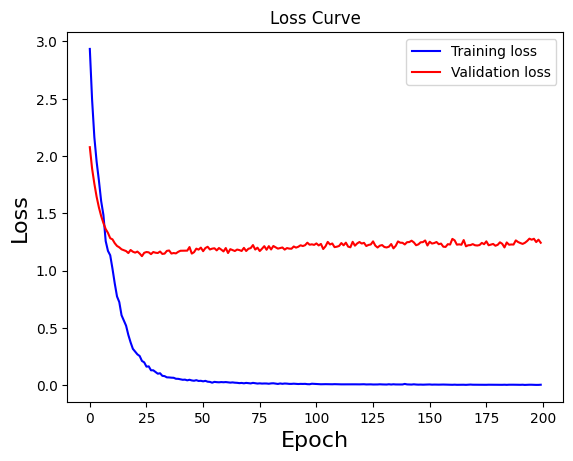

A Jupyter Widget

Epoch 0: iteration 34/35
Epoch 0 --- loss:3.170, Epoch accuracy:14.91%, Validation loss:2.203, Validation accuracy:21.67%
Epoch 1: iteration 34/35
Epoch 1 --- loss:2.637, Epoch accuracy:20.44%, Validation loss:2.104, Validation accuracy:25.67%
Epoch 2: iteration 34/35
Epoch 2 --- loss:2.196, Epoch accuracy:24.39%, Validation loss:1.843, Validation accuracy:31.00%
Epoch 3: iteration 34/35
Epoch 3 --- loss:1.881, Epoch accuracy:32.63%, Validation loss:1.643, Validation accuracy:41.00%
Epoch 4: iteration 34/35
Epoch 4 --- loss:1.621, Epoch accuracy:39.21%, Validation loss:1.542, Validation accuracy:43.00%
Epoch 5: iteration 34/35
Epoch 5 --- loss:1.479, Epoch accuracy:44.82%, Validation loss:1.456, Validation accuracy:43.00%
Epoch 6: iteration 34/35
Epoch 6 --- loss:1.369, Epoch accuracy:50.00%, Validation loss:1.427, Validation accuracy:46.00%
Epoch 7: iteration 34/35
Epoch 7 --- loss:1.218, Epoch accuracy:56.84%, Validation loss:1.381, Validation accuracy:48.67%
Epoch 8: iteration 34/35

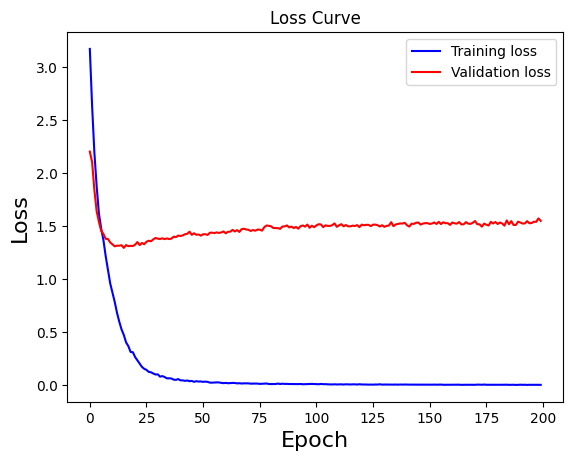

A Jupyter Widget

Epoch 0: iteration 34/35
Epoch 0 --- loss:2.481, Epoch accuracy:15.00%, Validation loss:1.904, Validation accuracy:29.00%
Epoch 1: iteration 34/35
Epoch 1 --- loss:2.179, Epoch accuracy:22.02%, Validation loss:1.804, Validation accuracy:34.67%
Epoch 2: iteration 34/35
Epoch 2 --- loss:2.016, Epoch accuracy:27.28%, Validation loss:1.669, Validation accuracy:43.67%
Epoch 3: iteration 34/35
Epoch 3 --- loss:1.859, Epoch accuracy:32.89%, Validation loss:1.605, Validation accuracy:43.00%
Epoch 4: iteration 34/35
Epoch 4 --- loss:1.666, Epoch accuracy:38.68%, Validation loss:1.525, Validation accuracy:46.67%
Epoch 5: iteration 34/35
Epoch 5 --- loss:1.489, Epoch accuracy:44.65%, Validation loss:1.477, Validation accuracy:46.67%
Epoch 6: iteration 34/35
Epoch 6 --- loss:1.330, Epoch accuracy:50.18%, Validation loss:1.472, Validation accuracy:44.67%
Epoch 7: iteration 34/35
Epoch 7 --- loss:1.232, Epoch accuracy:55.00%, Validation loss:1.413, Validation accuracy:50.33%
Epoch 8: iteration 34/35

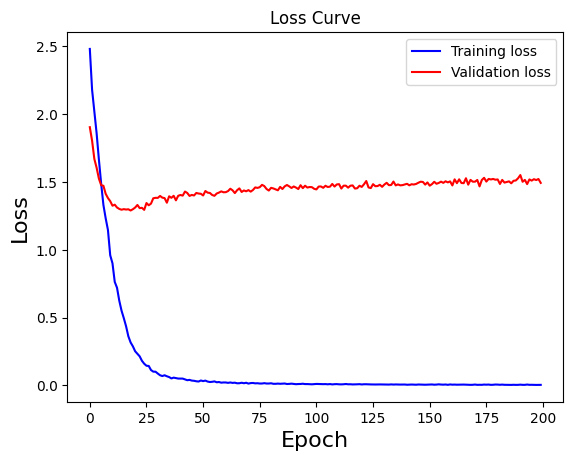

A Jupyter Widget

Epoch 0: iteration 34/35
Epoch 0 --- loss:2.916, Epoch accuracy:13.68%, Validation loss:2.052, Validation accuracy:15.00%
Epoch 1: iteration 34/35
Epoch 1 --- loss:2.411, Epoch accuracy:19.82%, Validation loss:1.893, Validation accuracy:27.67%
Epoch 2: iteration 34/35
Epoch 2 --- loss:2.085, Epoch accuracy:24.91%, Validation loss:1.774, Validation accuracy:33.33%
Epoch 3: iteration 34/35
Epoch 3 --- loss:1.867, Epoch accuracy:32.54%, Validation loss:1.662, Validation accuracy:37.67%
Epoch 4: iteration 34/35
Epoch 4 --- loss:1.625, Epoch accuracy:40.18%, Validation loss:1.596, Validation accuracy:40.67%
Epoch 5: iteration 34/35
Epoch 5 --- loss:1.528, Epoch accuracy:43.25%, Validation loss:1.564, Validation accuracy:45.00%
Epoch 6: iteration 34/35
Epoch 6 --- loss:1.348, Epoch accuracy:50.18%, Validation loss:1.522, Validation accuracy:44.67%
Epoch 7: iteration 34/35
Epoch 7 --- loss:1.204, Epoch accuracy:56.40%, Validation loss:1.487, Validation accuracy:45.67%
Epoch 8: iteration 34/35

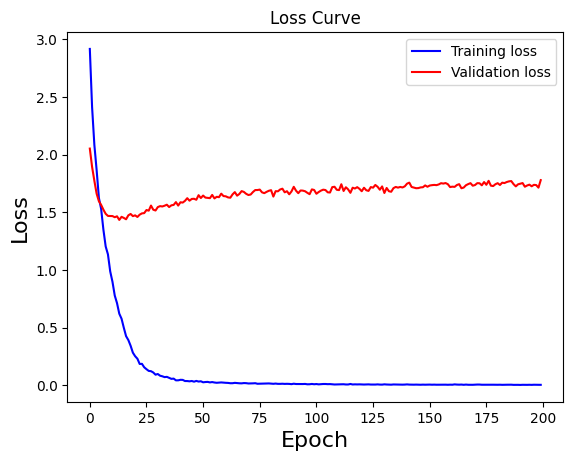

A Jupyter Widget

Epoch 0: iteration 36/37
Epoch 0 --- loss:2.991, Epoch accuracy:13.42%, Validation loss:2.101, Validation accuracy:21.25%
Epoch 1: iteration 36/37
Epoch 1 --- loss:2.456, Epoch accuracy:16.92%, Validation loss:1.944, Validation accuracy:29.17%
Epoch 2: iteration 36/37
Epoch 2 --- loss:2.085, Epoch accuracy:26.42%, Validation loss:1.860, Validation accuracy:32.92%
Epoch 3: iteration 36/37
Epoch 3 --- loss:1.878, Epoch accuracy:32.17%, Validation loss:1.735, Validation accuracy:35.00%
Epoch 4: iteration 36/37
Epoch 4 --- loss:1.740, Epoch accuracy:35.75%, Validation loss:1.695, Validation accuracy:37.50%
Epoch 5: iteration 36/37
Epoch 5 --- loss:1.499, Epoch accuracy:45.00%, Validation loss:1.635, Validation accuracy:41.25%
Epoch 6: iteration 36/37
Epoch 6 --- loss:1.394, Epoch accuracy:48.92%, Validation loss:1.592, Validation accuracy:40.00%
Epoch 7: iteration 36/37
Epoch 7 --- loss:1.244, Epoch accuracy:53.42%, Validation loss:1.543, Validation accuracy:45.00%
Epoch 8: iteration 36/37

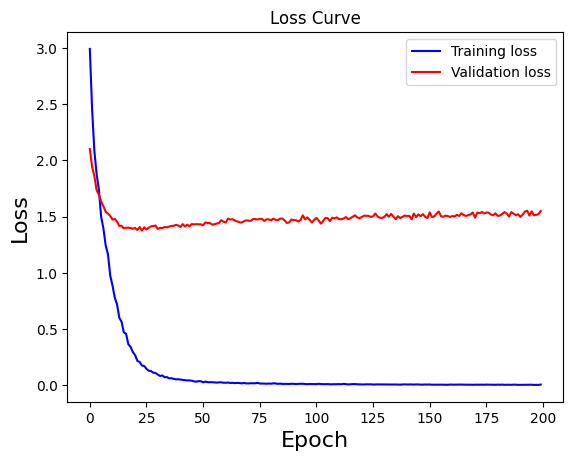

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

train_losses, valid_losses = [], []

print(f'[*] model training - {sub_name}')

fold_path = '5-CV'

for fold in range(5):
    cur_fold_path = os.path.join(fold_path, 'fold'+str(fold)+'.npy')
    X_train, y_train, X_test, y_test = get_fold_dataset(cur_fold_path)
    
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    model = Model(num_emotions=len(emotions_dict)).to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)
    
    train_losses, valid_losses = train(model, num_epochs, X_train, y_train, X_test, y_test, pkl_name, fold, optimizer)
    
    plt.title('Loss Curve')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(train_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])
    plt.show()

[*] Fold-0
Test accuracy is 58.67%
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        20
           1       0.85      0.57      0.69        40
           2       0.52      0.42      0.47        40
           3       0.33      0.38      0.35        40
           4       0.55      0.78      0.65        40
           5       0.62      0.72      0.67        40
           6       0.70      0.47      0.57        40
           7       0.73      0.80      0.76        40

    accuracy                           0.59       300
   macro avg       0.60      0.58      0.58       300
weighted avg       0.61      0.59      0.59       300



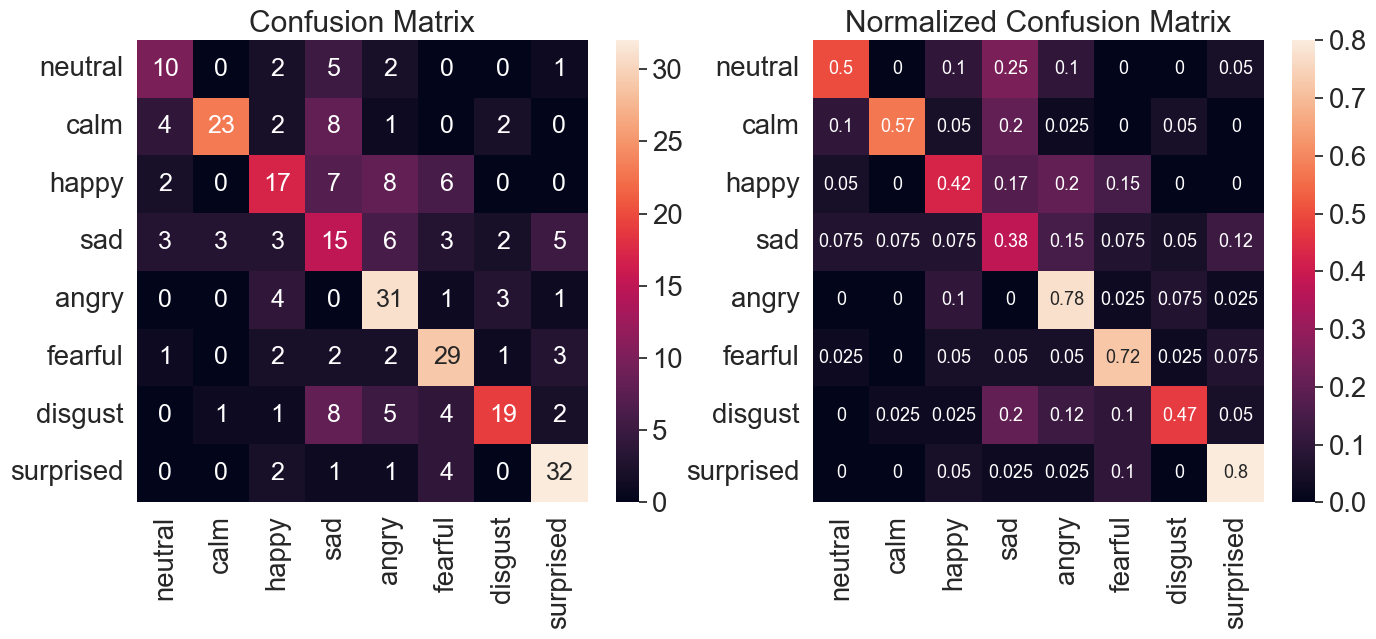

[*] Fold-1
Test accuracy is 55.00%
              precision    recall  f1-score   support

           0       0.50      0.30      0.37        20
           1       0.67      0.75      0.71        40
           2       0.32      0.33      0.32        40
           3       0.56      0.35      0.43        40
           4       0.73      0.55      0.63        40
           5       0.51      0.55      0.53        40
           6       0.53      0.62      0.57        40
           7       0.58      0.82      0.68        40

    accuracy                           0.55       300
   macro avg       0.55      0.53      0.53       300
weighted avg       0.55      0.55      0.54       300



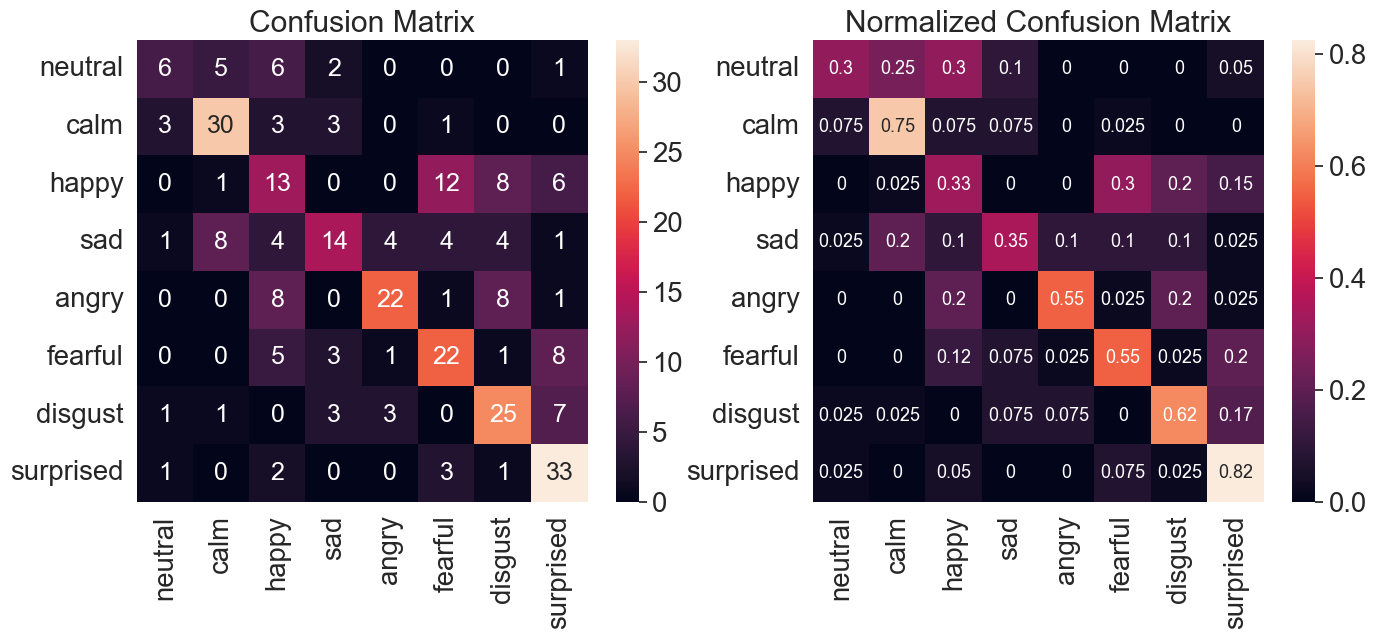

[*] Fold-2
Test accuracy is 51.00%
              precision    recall  f1-score   support

           0       0.38      0.15      0.21        20
           1       0.60      0.80      0.69        40
           2       0.31      0.42      0.36        40
           3       0.32      0.30      0.31        40
           4       0.65      0.65      0.65        40
           5       0.38      0.42      0.40        40
           6       0.72      0.65      0.68        40
           7       0.74      0.50      0.60        40

    accuracy                           0.51       300
   macro avg       0.51      0.49      0.49       300
weighted avg       0.52      0.51      0.51       300



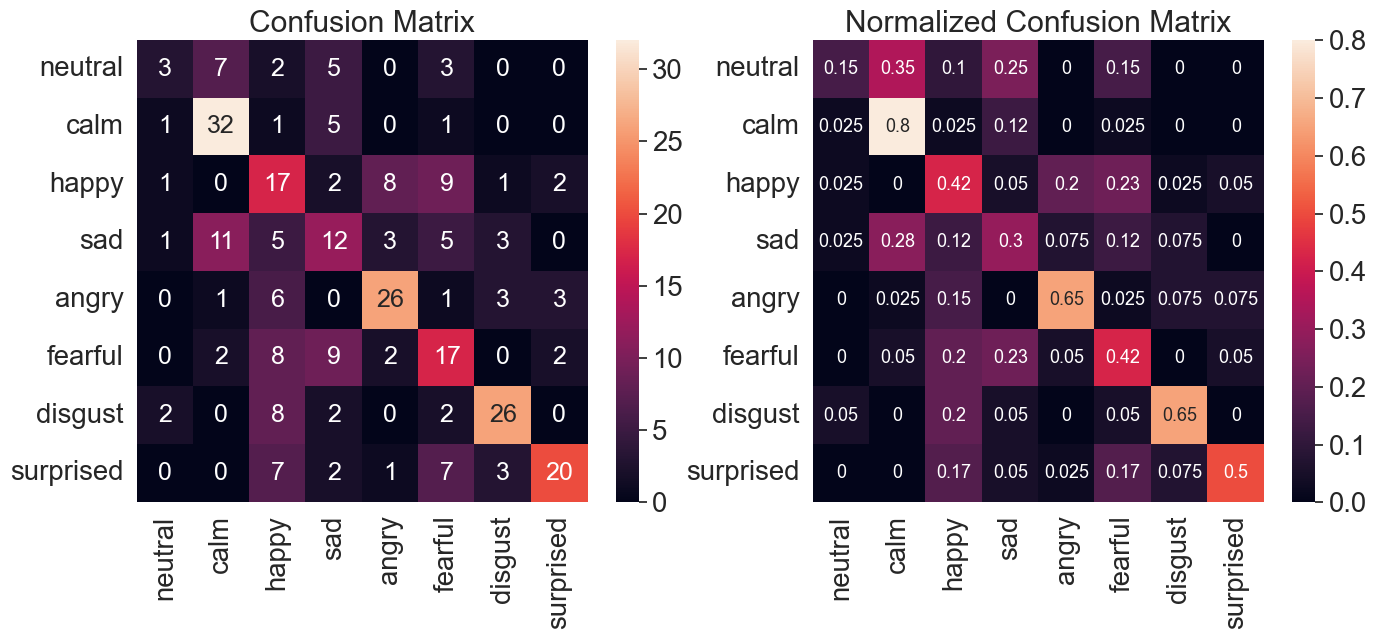

[*] Fold-3
Test accuracy is 47.33%
              precision    recall  f1-score   support

           0       0.33      0.25      0.29        20
           1       0.44      0.60      0.51        40
           2       0.36      0.23      0.28        40
           3       0.11      0.07      0.09        40
           4       0.59      0.47      0.53        40
           5       0.52      0.35      0.42        40
           6       0.52      0.88      0.65        40
           7       0.63      0.82      0.72        40

    accuracy                           0.47       300
   macro avg       0.44      0.46      0.43       300
weighted avg       0.45      0.47      0.44       300



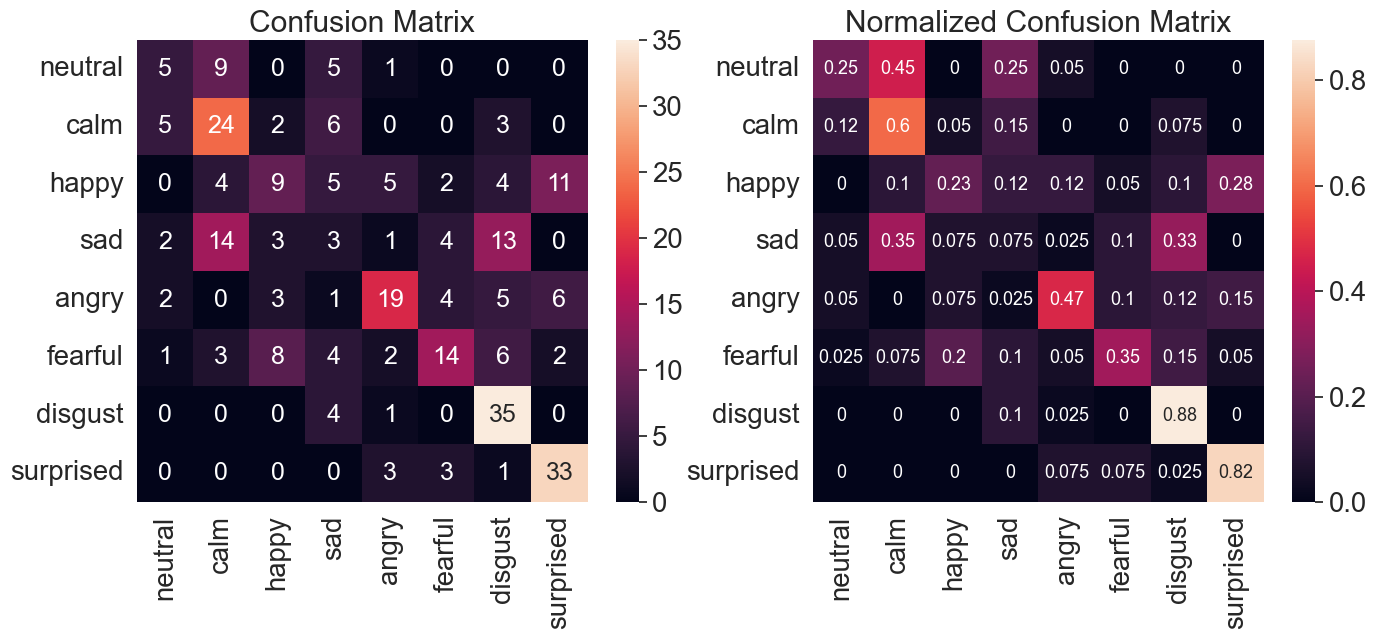

[*] Fold-4
Test accuracy is 52.92%
              precision    recall  f1-score   support

           0       0.10      0.06      0.08        16
           1       0.65      0.75      0.70        32
           2       0.44      0.44      0.44        32
           3       0.35      0.44      0.39        32
           4       0.59      0.72      0.65        32
           5       0.64      0.56      0.60        32
           6       0.43      0.41      0.42        32
           7       0.83      0.62      0.71        32

    accuracy                           0.53       240
   macro avg       0.50      0.50      0.50       240
weighted avg       0.53      0.53      0.53       240



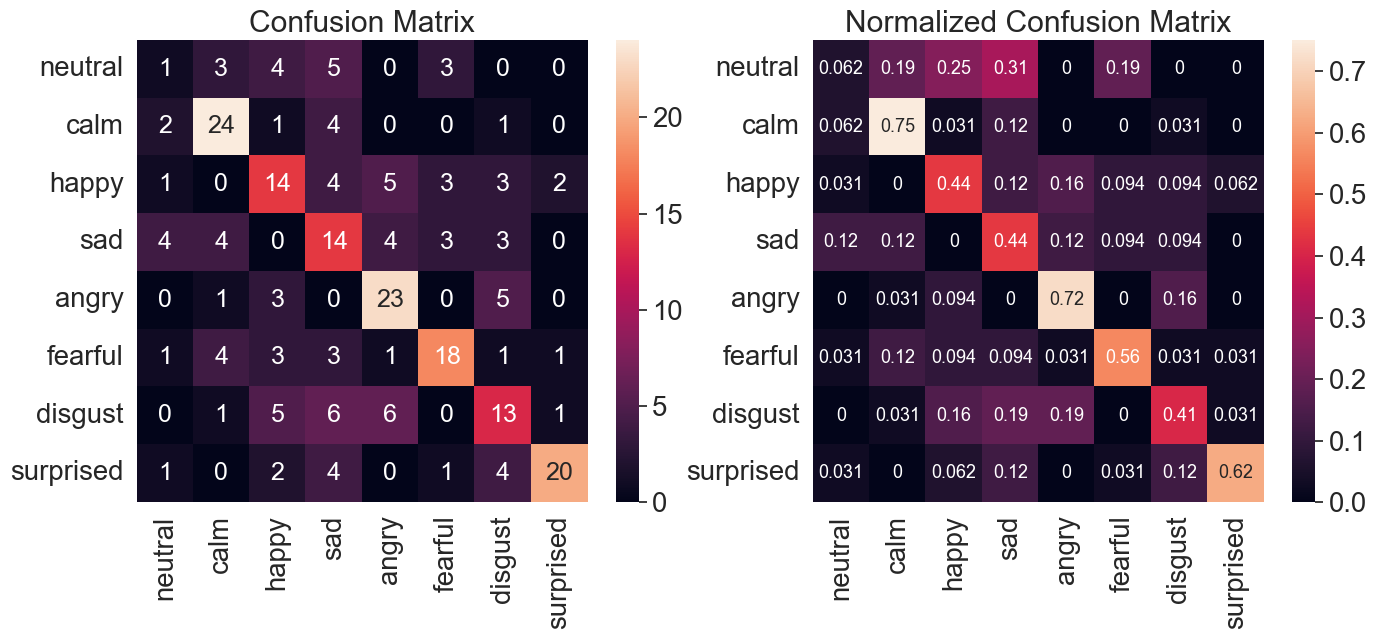

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report

device = 'cuda'
model = Model(num_emotions=len(emotions_dict)).to('cuda')

test_accs = []

for fold in range(5):
    pkl_name = f'./model/{data_name}-{sub_name}-{fold}.pkl'
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)
    
    load_checkpoint(optimizer, model, pkl_name)
    
    validate = make_validate_fnc(model, criterion)
    
    cur_fold_path = os.path.join(fold_path, 'fold'+str(fold)+'.npy')
    X_train, y_train, X_test, y_test = get_fold_dataset(cur_fold_path)
    
    X_test_tensor = torch.tensor(X_test,device=device).float()
    # X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)
    y_test_tensor = torch.tensor(y_test,dtype=torch.long,device=device)
    
    test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)
    
    print("="*40)
    print(f'[*] Fold-{fold}')
    print(f'Test accuracy is {test_acc:.2f}%')
    test_accs.append(test_acc)
    
    predicted_emotions = predicted_emotions.cpu().numpy()
    # use labels from test set
    emotions_groundtruth = y_test_tensor.cpu().numpy()
    
    print(classification_report(emotions_groundtruth, predicted_emotions))
    
    # build confusion matrix and normalized confusion matrix
    conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
    conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

    # set labels for matrix axes from emotions
    emotion_names = [emotion for emotion in emotions_dict.values()]

    # make a confusion matrix with labels using a DataFrame
    confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
    confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

    # plot confusion matrices
    plt.figure(figsize=(16,6))
    sn.set(font_scale=1.8) # emotion label and title size
    plt.subplot(1,2,1)
    plt.title('Confusion Matrix')
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
    plt.subplot(1,2,2)
    plt.title('Normalized Confusion Matrix')
    sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

    plt.show()
    print("="*40)

In [19]:
def Average(lst):
    return sum(lst) / len(lst)

print('[*] K-Fold training done !')
print(f'[*] Best fold acc : {max(test_accs):.2f}%')
print(f'[*] Worst fold acc : {min(test_accs):.2f}%')
print(f'[*] Average fold acc : {Average(test_accs):.2f}%')

[*] K-Fold training done !
[*] Best fold acc : 58.67%
[*] Worst fold acc : 47.33%
[*] Average fold acc : 52.98%
